## ⭐For the starters...
This notebook refers to [RAPIDS cudf Feature Engineering + XGB](https://www.kaggle.com/code/jiweiliu/rapids-cudf-feature-engineering-xgb), where I learnt how to read using GPU! And what I have done in this notebook is design a simple stacking model with xgb & lgbm.

You can choose your own stacking model. Here I applied LogisticRegression.



#### This is my first shared notebook, upvote it if u like! :3

In [1]:
import cudf
import cupy
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
import pickle
import gc

import pandas as pd
import numpy as np
from tqdm import tqdm
cudf.__version__

'21.10.01'

### Feature Engineering

In [2]:
def get_not_used():
    # cid is the label encode of customer_ID
    # row_id indicates the order of rows
    misscols= ['D_88','D_110','B_39','D_73','B_42','D_134','B_29','D_76','D_132','D_42','D_142','D_53']
    skew=['B_31', 'D_87']
    return ['row_id', 'customer_ID', 'target', 'cid', 'S_2','month']+skew+misscols[:-5]
    
def preprocess(df):
    df['row_id'] = cupy.arange(df.shape[0])
    not_used = get_not_used()
    cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',
                'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

    for col in df.columns:
        if col not in not_used+cat_cols:
            df[col] = df[col].round(2)

    df['S_2'] = cudf.to_datetime(df['S_2'])
    df['cid'], _ = df.customer_ID.factorize()
    df= df.sort_values(['customer_ID','S_2'])
    df['month']= df['S_2'].dt.day
    df['month'] =df.to_pandas().groupby('customer_ID')['month'].diff()
    
    important = ['P_2','B_1','B_4','D_39']
    num_cols = [col for col in df.columns if col not in cat_cols+not_used]+['month']
    nth_cols = [col for col in df.columns if col not in cat_cols+not_used][:30]+['customer_ID']
    
    dgs = add_stats_step(df, num_cols, cat_cols)
        
    # cudf merge changes row orders
    # restore the original row order by sorting row_id
    df= df.merge(df[nth_cols].groupby('customer_ID').nth(-2),on='customer_ID',how='left',suffixes=["_last_1","_last_2"])
    df = df.sort_values('row_id')
    df = df.drop(['row_id'],axis=1)
    return df, dgs

def add_stats_step(df, numcols, catcols):
    n = 50
    dgs = []
    for i in range(0,len(numcols),n):
        s = i
        e = min(s+n, len(numcols))
        dg = add_stats_one_shot_num(df, numcols[s:e])
        dgs.append(dg)
    for i in range(0,len(catcols),n):
        s = i
        e = min(s+n, len(catcols))
        dg = add_stats_one_shot_cat(df, catcols[s:e])
        dgs.append(dg)
    return dgs

def add_stats_one_shot_num(df, cols):
    stats = ['mean','max','min','std']
    dg = df.groupby('customer_ID').agg({col:stats for col in cols})
    out_cols = []
    for col in cols:
        out_cols.extend([f'{col}_{s}' for s in stats])
    dg.columns = out_cols
    dg = dg.reset_index()
    return dg

def add_stats_one_shot_cat(df, cols):
    stats = ['count', 'nunique']
    dg = df.groupby('customer_ID').agg({col:stats for col in cols})
    out_cols = []
    for col in cols:
        out_cols.extend([f'{col}_{s}' for s in stats])
    dg.columns = out_cols
    dg = dg.reset_index()
    return dg

def load_test_iter(path, chunks=4):
    
    test_rows = 11363762
    chunk_rows = test_rows // chunks
    
    test = cudf.read_parquet(f'{path}/test.parquet',
                             columns=['customer_ID','S_2'],
                             num_rows=test_rows)
    test = get_segment(test)
    start = 0
    while start < test.shape[0]:
        if start+chunk_rows < test.shape[0]:
            end = test['cus_count'].values[start+chunk_rows]
        else:
            end = test['cus_count'].values[-1]
        end = int(end)
        df = cudf.read_parquet(f'{path}/test.parquet',
                               num_rows = end-start, skiprows=start)
        start = end
        yield process_data(df)

def load_train(path):
    train = cudf.read_parquet(f'{path}/train.parquet')
    
    train = process_data(train)
    trainl = cudf.read_csv(f'../input/amex-default-prediction/train_labels.csv')
    train = train.merge(trainl, on='customer_ID', how='left')
    return train

def process_data(df):
    df,dgs = preprocess(df)
    df = df.drop_duplicates('customer_ID',keep='last')
    for dg in dgs:
        df = df.merge(dg, on='customer_ID', how='left')
#     diff_cols = [col for col in df.columns if col.endswith('_diff')]
#     df = df.drop(diff_cols,axis=1)
    return df


def get_segment(test):
    dg = test.groupby('customer_ID').agg({'S_2':'count'})
    dg.columns = ['cus_count']
    dg = dg.reset_index()
    dg['cid'],_ = dg['customer_ID'].factorize()
    dg = dg.sort_values('cid')
    dg['cus_count'] = dg['cus_count'].cumsum()
    
    test = test.merge(dg, on='customer_ID', how='left')
    test = test.sort_values(['cid','S_2'])
    assert test['cus_count'].values[-1] == test.shape[0]
    return test

### XGB/LGB Params and utility functions

In [3]:
def xgb_train(x, y, xt, yt):
    print("-----------xgb starts training-----------")
    print("# of features:", x.shape[1])
    assert x.shape[1] == xt.shape[1]
    dtrain = xgb.DMatrix(data=x, label=y)
    dvalid = xgb.DMatrix(data=xt, label=yt)
    params = {
            'objective': 'binary:logistic', 
            'tree_method': 'gpu_hist', 
            'max_depth': 7,
            'subsample':0.88,
            'colsample_bytree': 0.5,
            'gamma':1.5,
            'min_child_weight':8,
            'lambda':70,
            'eta':0.03,
#             'scale_pos_weight': scale_pos_weight,
    }
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    bst = xgb.train(params, dtrain=dtrain,
                num_boost_round=2600,evals=watchlist,
                early_stopping_rounds=500, feval=xgb_amex, maximize=True,
                verbose_eval=100)
    print('best ntree_limit:', bst.best_ntree_limit)
    print('best score:', bst.best_score)
    return bst.predict(dtrain, iteration_range=(0,bst.best_ntree_limit)), bst.predict(dvalid, iteration_range=(0,bst.best_ntree_limit)), bst

In [4]:
def lgb_train(x, y, xt, yt):
    print("----------lgb starts training----------")
    print("# of features:", x.shape[1])
    assert x.shape[1] == xt.shape[1]
    lgb_train = lgb.Dataset(x.to_pandas(), y.to_pandas())
    lgb_eval = lgb.Dataset(xt.to_pandas(), yt.to_pandas(), reference=lgb_train)

    params = {
        'boosting_type': 'gbdt',
        'n_estimators': 2000,
        'learning_rate': 0.05,
#         'min_child_samples': 2000,
        'reg_lambda':10,
        'feature_fraction':0.3,
        'bagging_fraction':0.3,
        'objective': 'binary',
    }
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=[lgb_train, lgb_eval],
                early_stopping_rounds=200,feval=amex_metric_mod_lgbm, 
                verbose_eval=100)


    print('best iterations:', gbm.best_iteration)
    print('best score:', gbm.best_score)
    return gbm.predict(x.to_pandas(), num_iteration =gbm.best_iteration),gbm.predict(xt.to_pandas(), num_iteration =gbm.best_iteration), gbm

### Metrics

In [5]:
def lgb_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label()), True

def xgb_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label())

# Created by https://www.kaggle.com/yunchonggan
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric_np(preds: np.ndarray, target: np.ndarray) -> float:
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)

    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)

    g = gini / gini_max
    return 0.5 * (g + d)

# we still need the official metric since the faster version above is slightly off
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def amex_metric_mod_lgbm(y_pred: np.ndarray, data: lgb.Dataset):

    y_true = data.get_label()
    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 'AMEX', 0.5 * (gini[1]/gini[0]+ top_four), True

### Load data and add feature

In [6]:
%%time

path = '../input/amex-data-integer-dtypes-parquet-format'
train = load_train(path)
# train2 = load_train(path,2)
train.shape

CPU times: user 1min 36s, sys: 12.2 s, total: 1min 48s
Wall time: 2min 4s


(458913, 921)

### Train Stacking Model in K-folds

In [7]:
%%time

not_used = get_not_used()
not_used = [i for i in not_used if i in train.columns]
msgs = {}
folds = 5
score = 0

#set diff cols if u wanna try different features on xgb & lgbm
diff_cols= [col for col in train.columns if col.endswith('_max') or col.endswith('_min') or col.endswith('_mean') or col.endswith('_std') or col.endswith('_count')]


for i in range(folds):
    print(f"==============Folds {i}===============")
    mask = train['cid']%folds == i
    tr,va = train[~mask], train[mask]

    x, y = tr.drop(not_used, axis=1), tr['target']
    xt, yt = va.drop(not_used, axis=1), va['target']
    
    xp, yp, bst = xgb_train(x, y, xt, yt)
    bst.save_model(f'xgb_{i}.json')

    x = tr.drop(not_used+diff_cols, axis=1)
    xt = va.drop(not_used+diff_cols, axis=1)
    
    xp2,yp2,gbm = lgb_train(x, y, xt, yt)
    gbm.save_model(f'lgb_{i}.json')

    X_estimator = np.concatenate((np.expand_dims(yp, 1), np.expand_dims(yp2, 1)), 1)
    final_estimator = LogisticRegression(penalty="l1",solver="saga",C=0.001,max_iter=1000,class_weight="balanced")
    final_estimator.fit(X_estimator, yt.to_pandas())
    with open(f'lr_{i}.pkl','wb') as f:
        pickle.dump(final_estimator, f)
    preds=final_estimator.predict_proba(np.concatenate((np.expand_dims(yp, 1), np.expand_dims(yp2, 1)), 1))[:,1]

    amex_score = amex_metric(pd.DataFrame({'target':yt.values.get()}), 
                                    pd.DataFrame({'prediction':preds}))
    msg = f"Fold {i} amex {amex_score:.4f}"
    print(msg)
    score += amex_score
score /= folds
print(f"Average amex score: {score:.4f}")

==============Folds 0===============
-----------xgb starts training-----------
# of features: 907


/opt/conda/lib/python3.7/site-packages/xgboost/training.py:36: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  "`feval` is deprecated, use `custom_metric` instead.  They have "


[0]	train-logloss:0.67374	train-amex:0.70766	eval-logloss:0.67380	eval-amex:0.69872
[100]	train-logloss:0.24266	train-amex:0.78034	eval-logloss:0.24786	eval-amex:0.76612
[200]	train-logloss:0.21749	train-amex:0.79838	eval-logloss:0.22696	eval-amex:0.77708
[300]	train-logloss:0.20875	train-amex:0.81058	eval-logloss:0.22234	eval-amex:0.78287
[400]	train-logloss:0.20315	train-amex:0.81894	eval-logloss:0.22015	eval-amex:0.78582
[500]	train-logloss:0.19869	train-amex:0.82600	eval-logloss:0.21885	eval-amex:0.78784
[600]	train-logloss:0.19477	train-amex:0.83261	eval-logloss:0.21809	eval-amex:0.78881
[700]	train-logloss:0.19124	train-amex:0.83837	eval-logloss:0.21754	eval-amex:0.78985
[800]	train-logloss:0.18796	train-amex:0.84390	eval-logloss:0.21712	eval-amex:0.79079
[900]	train-logloss:0.18467	train-amex:0.84989	eval-logloss:0.21676	eval-amex:0.79107
[1000]	train-logloss:0.18163	train-amex:0.85556	eval-logloss:0.21652	eval-amex:0.79107
[1100]	train-logloss:0.17863	train-amex:0.86086	eval-lo

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 95258, number of negative: 271872
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.287211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20528
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 220
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.259467 -> initscore=-1.048742
[LightGBM] [Info] Start training from score -1.048742
Training until validation scores don't improve for 200 rounds
[100]	training's binary_logloss: 0.229631	training's AMEX: 0.779552	valid_1's binary_logloss: 0.232923	valid_1's AMEX: 0.770874
[200]	training's binary_logloss: 0.217656	training's AMEX: 0.794304	valid_1's binary_logloss: 0.224373	valid_1's AMEX: 0.781524
[300]	training's binary_logloss: 0.212109	training's AMEX: 0.803209	valid_1's binary_logloss: 0.221941	valid_1's AMEX

/opt/conda/lib/python3.7/site-packages/xgboost/training.py:36: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  "`feval` is deprecated, use `custom_metric` instead.  They have "


[0]	train-logloss:0.67374	train-amex:0.70599	eval-logloss:0.67382	eval-amex:0.70341
[100]	train-logloss:0.24233	train-amex:0.77990	eval-logloss:0.24874	eval-amex:0.76858
[200]	train-logloss:0.21712	train-amex:0.79749	eval-logloss:0.22806	eval-amex:0.77928
[300]	train-logloss:0.20830	train-amex:0.81043	eval-logloss:0.22341	eval-amex:0.78335
[400]	train-logloss:0.20264	train-amex:0.81872	eval-logloss:0.22122	eval-amex:0.78527
[500]	train-logloss:0.19793	train-amex:0.82678	eval-logloss:0.21989	eval-amex:0.78800
[600]	train-logloss:0.19391	train-amex:0.83379	eval-logloss:0.21903	eval-amex:0.78947
[700]	train-logloss:0.19026	train-amex:0.84009	eval-logloss:0.21843	eval-amex:0.78992
[800]	train-logloss:0.18699	train-amex:0.84567	eval-logloss:0.21802	eval-amex:0.79066
[900]	train-logloss:0.18377	train-amex:0.85163	eval-logloss:0.21764	eval-amex:0.79113
[1000]	train-logloss:0.18087	train-amex:0.85624	eval-logloss:0.21731	eval-amex:0.79176
[1100]	train-logloss:0.17787	train-amex:0.86182	eval-lo

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 95167, number of negative: 271963
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.291090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20565
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 220
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.259219 -> initscore=-1.050033
[LightGBM] [Info] Start training from score -1.050033
Training until validation scores don't improve for 200 rounds
[100]	training's binary_logloss: 0.229438	training's AMEX: 0.779218	valid_1's binary_logloss: 0.233992	valid_1's AMEX: 0.771598
[200]	training's binary_logloss: 0.217496	training's AMEX: 0.794945	valid_1's binary_logloss: 0.225454	valid_1's AMEX: 0.779546
[300]	training's binary_logloss: 0.211936	training's AMEX: 0.803598	valid_1's binary_logloss: 0.222884	valid_1's AMEX

/opt/conda/lib/python3.7/site-packages/xgboost/training.py:36: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  "`feval` is deprecated, use `custom_metric` instead.  They have "


[0]	train-logloss:0.67374	train-amex:0.70959	eval-logloss:0.67384	eval-amex:0.70069
[100]	train-logloss:0.24232	train-amex:0.78153	eval-logloss:0.24901	eval-amex:0.76780
[200]	train-logloss:0.21740	train-amex:0.79839	eval-logloss:0.22781	eval-amex:0.78087
[300]	train-logloss:0.20860	train-amex:0.81104	eval-logloss:0.22265	eval-amex:0.78738
[400]	train-logloss:0.20288	train-amex:0.81958	eval-logloss:0.22020	eval-amex:0.79036
[500]	train-logloss:0.19835	train-amex:0.82682	eval-logloss:0.21883	eval-amex:0.79180
[600]	train-logloss:0.19470	train-amex:0.83319	eval-logloss:0.21801	eval-amex:0.79248
[700]	train-logloss:0.19108	train-amex:0.83907	eval-logloss:0.21735	eval-amex:0.79409
[800]	train-logloss:0.18789	train-amex:0.84458	eval-logloss:0.21694	eval-amex:0.79461
[900]	train-logloss:0.18477	train-amex:0.85019	eval-logloss:0.21661	eval-amex:0.79554
[1000]	train-logloss:0.18166	train-amex:0.85586	eval-logloss:0.21630	eval-amex:0.79624
[1100]	train-logloss:0.17890	train-amex:0.86067	eval-lo

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 94985, number of negative: 272145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.295698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20539
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 220
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258723 -> initscore=-1.052616
[LightGBM] [Info] Start training from score -1.052616
Training until validation scores don't improve for 200 rounds
[100]	training's binary_logloss: 0.229554	training's AMEX: 0.779396	valid_1's binary_logloss: 0.233792	valid_1's AMEX: 0.773295
[200]	training's binary_logloss: 0.217766	training's AMEX: 0.794751	valid_1's binary_logloss: 0.224899	valid_1's AMEX: 0.782668
[300]	training's binary_logloss: 0.212217	training's AMEX: 0.802551	valid_1's binary_logloss: 0.222278	valid_1's AMEX

/opt/conda/lib/python3.7/site-packages/xgboost/training.py:36: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  "`feval` is deprecated, use `custom_metric` instead.  They have "


[0]	train-logloss:0.67375	train-amex:0.70647	eval-logloss:0.67379	eval-amex:0.70290
[100]	train-logloss:0.24254	train-amex:0.78003	eval-logloss:0.24769	eval-amex:0.77062
[200]	train-logloss:0.21751	train-amex:0.79682	eval-logloss:0.22662	eval-amex:0.78113
[300]	train-logloss:0.20873	train-amex:0.81017	eval-logloss:0.22183	eval-amex:0.78695
[400]	train-logloss:0.20317	train-amex:0.81820	eval-logloss:0.21954	eval-amex:0.79026
[500]	train-logloss:0.19858	train-amex:0.82562	eval-logloss:0.21817	eval-amex:0.79196
[600]	train-logloss:0.19454	train-amex:0.83293	eval-logloss:0.21728	eval-amex:0.79312
[700]	train-logloss:0.19104	train-amex:0.83929	eval-logloss:0.21669	eval-amex:0.79389
[800]	train-logloss:0.18765	train-amex:0.84487	eval-logloss:0.21621	eval-amex:0.79431
[900]	train-logloss:0.18466	train-amex:0.85031	eval-logloss:0.21589	eval-amex:0.79498
[1000]	train-logloss:0.18177	train-amex:0.85548	eval-logloss:0.21564	eval-amex:0.79550
[1100]	train-logloss:0.17872	train-amex:0.86116	eval-lo

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 94856, number of negative: 272275
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.301599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20539
[LightGBM] [Info] Number of data points in the train set: 367131, number of used features: 220
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258371 -> initscore=-1.054453
[LightGBM] [Info] Start training from score -1.054453
Training until validation scores don't improve for 200 rounds
[100]	training's binary_logloss: 0.22977	training's AMEX: 0.779298	valid_1's binary_logloss: 0.232745	valid_1's AMEX: 0.773493
[200]	training's binary_logloss: 0.217834	training's AMEX: 0.794492	valid_1's binary_logloss: 0.223803	valid_1's AMEX: 0.783346
[300]	training's binary_logloss: 0.212289	training's AMEX: 0.802839	valid_1's binary_logloss: 0.221152	valid_1's AMEX:

/opt/conda/lib/python3.7/site-packages/xgboost/training.py:36: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  "`feval` is deprecated, use `custom_metric` instead.  They have "


[0]	train-logloss:0.67372	train-amex:0.70639	eval-logloss:0.67378	eval-amex:0.70221
[100]	train-logloss:0.24236	train-amex:0.78185	eval-logloss:0.24866	eval-amex:0.76611
[200]	train-logloss:0.21730	train-amex:0.79817	eval-logloss:0.22814	eval-amex:0.77891
[300]	train-logloss:0.20845	train-amex:0.81115	eval-logloss:0.22343	eval-amex:0.78563
[400]	train-logloss:0.20251	train-amex:0.82039	eval-logloss:0.22128	eval-amex:0.78864
[500]	train-logloss:0.19804	train-amex:0.82767	eval-logloss:0.22004	eval-amex:0.79043
[600]	train-logloss:0.19417	train-amex:0.83458	eval-logloss:0.21930	eval-amex:0.79116
[700]	train-logloss:0.19072	train-amex:0.84052	eval-logloss:0.21874	eval-amex:0.79145
[800]	train-logloss:0.18730	train-amex:0.84667	eval-logloss:0.21835	eval-amex:0.79237
[900]	train-logloss:0.18413	train-amex:0.85236	eval-logloss:0.21807	eval-amex:0.79239
[1000]	train-logloss:0.18105	train-amex:0.85783	eval-logloss:0.21784	eval-amex:0.79290
[1100]	train-logloss:0.17807	train-amex:0.86342	eval-lo

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 95046, number of negative: 272085
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.294276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20534
[LightGBM] [Info] Number of data points in the train set: 367131, number of used features: 220
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258889 -> initscore=-1.051754
[LightGBM] [Info] Start training from score -1.051754
Training until validation scores don't improve for 200 rounds
[100]	training's binary_logloss: 0.229566	training's AMEX: 0.779107	valid_1's binary_logloss: 0.233363	valid_1's AMEX: 0.771706
[200]	training's binary_logloss: 0.217637	training's AMEX: 0.79378	valid_1's binary_logloss: 0.224798	valid_1's AMEX: 0.783798
[300]	training's binary_logloss: 0.21208	training's AMEX: 0.802872	valid_1's binary_logloss: 0.222184	valid_1's AMEX: 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

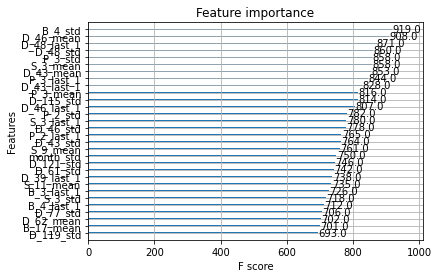

In [8]:
from xgboost import plot_importance
plot_importance(bst,max_num_features=30)


In [9]:
del train
del tr,va
gc.collect()

25

### Inference

In [10]:
%%time
cids = []
yps = []
# set chunks 
chunks = 10


for df in tqdm(load_test_iter(path,chunks),total=chunks):
    cids.append(df['customer_ID'])
    not_used = [i for i in not_used if i in df.columns]

    preds=0
    for i in range(folds):
        bst = xgb.Booster()
        bst.load_model(f'xgb_{i}.json')
        dx = xgb.DMatrix(df.drop(not_used, axis=1))
        
        gbm = lgb.Booster(model_file=f'lgb_{i}.json')
        dx2 = df.drop(not_used+diff_cols, axis=1).to_pandas()
        
        with open(f'lr_{i}.pkl','rb') as f:
            Lr= pickle.load(f)
        
        yp = bst.predict(dx, iteration_range=(0,bst.best_ntree_limit))
        yp2 = gbm.predict(dx2, num_iteration =gbm.best_iteration)
        preds+=final_estimator.predict_proba(np.concatenate((np.expand_dims(yp, 1), np.expand_dims(yp2, 1)), 1))[:,1]
        
    yps.append(preds/folds)
    
df = cudf.DataFrame()
df['customer_ID'] = cudf.concat(cids)
df['prediction'] = np.concatenate(yps)
df.head()

100%|██████████| 10/10 [18:39<00:00, 111.91s/it]

CPU times: user 28min 46s, sys: 42.8 s, total: 29min 28s
Wall time: 18min 39s


,customer_ID,prediction
0,01b105a265d342326aab69904d750d35a04c4bea5e0660...,0.104155
1,01b157e354d3eb942174f33fc7b3a641ff5a608b95dcff...,0.943266
2,01b180b8a00f861af43118a49312a7ba2a934df5122372...,0.143880
3,01b22bdd08c342e5ea3dcbe3692571475e447241fa9248...,0.095000
4,01b25531b34c5a1c2b587537e53858f0fb13d55993aaa9...,0.967836


In [11]:
df.to_csv('submission.csv',index=False)